# Implémentation de l’Architecture Transformer avec NumPy

## Construction des mécanismes d’attention et des blocs Encodeur/Décodeur

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#Part I: Le Sens de l’Ordre: Positional Encoding

##Problem 1: Implémentation du Positional Encoding (PE)

###a) Création d'une fonction Python create_positional_encoding(max_len, d_model)

###b) Dans cette fonction, pré-calculez et retournez la matrice de Positional Encoding de taille (max_len, d_model)




In [ ]:
def create_positional_encoding(max_len, d_model):
  # création de la matrice PE de taile (max_len, d_model) de zeros
  pe = np.zeros((max_len, d_model))

  #création du vecteur de position et du terme de division
  pos = np.arange(0, max_len).reshape(max_len, 1)
  div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000) / d_model))
  #implémentation du positionnal encoding
  pe[:, 0::2] = np.sin(pos * div_term)
  pe[:, 1::2] = np.cos(pos * div_term)
  return pe

###c) Test : Créez une matrice d’embeddings aléatoire x de taille (1, 10, 512) avec NumPy. Générez la matrice de PE correspondante et additionnez-la à x

In [ ]:
x = np.random.rand(1, 10, 512)
pe = create_positional_encoding(10, 512)
x_pe = x + pe

###d) Visualisation : Appelez votre fonction avec d_model=128 et max_len=100. Utilisez matplotlib.pyplot.imshow pour afficher la matrice de

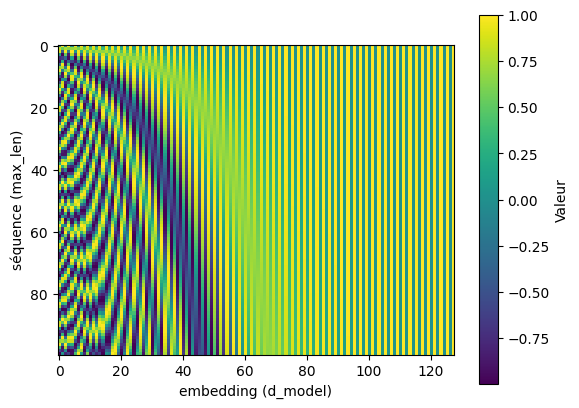

In [ ]:
pe = create_positional_encoding(100,128)
plt.imshow(pe)
plt.xlabel("embedding (d_model)")
plt.ylabel("séquence (max_len)")
plt.colorbar(label="Valeur")
plt.show()

#Part II: Le Cœur du Réacteur: Self-Attention

##Problem 2: Implémentation du Scaled Dot-Product Attention

###a) Ecrivez une fonction Python scaled_dot_product_attention(Q, K, V,mask=None)

In [ ]:
def  scaled_dot_product_attention(Q, K, V,mask=None):
  # b) calcul des score
  score = Q @ K.swapaxes(-2, -1)

  #c) mise à l'échelle
  scaled_score = score/np.sqrt(Q.shape[-1])
  ## elle permet de garder une variance de 1 et de ne pas saturer le softmax.

  #d) Masquag
  if mask is not None:
    scaled_score = np.where(mask, scaled_score, -1e9)

  #e) Softmax
  exp_score = np.exp(scaled_score - np.max(scaled_score, axis=-1, keepdims=True))
  attention_weights = exp_score / np.sum(exp_score, axis=-1, keepdims=True)

  #f) sortie
  Z = attention_weights @ V

  #g) la fonction retourne Z et attention_qeights
  return Z , attention_weights

#Part III: Assemblage Multi-Head et Bloc Encodeur

##Problem 3: Construction de la Multi-Head Attention (MHA)

###a) Créez une classe Python MultiHeadAttention.



In [ ]:
class MultiHeadAttention():

  #b) Le constructeur __init__
  def __init__(self, d_model, n_heads):
    self.d_model = d_model
    self.num_heads = n_heads
    self.d_k =  d_model // n_heads
    self.W_q = np.random.randn(d_model, d_model)
    self.W_k = np.random.randn(d_model, d_model)
    self.W_v = np.random.randn(d_model, d_model)
    self.W_o = np.random.randn(d_model, d_model)

    ### c) Création d'une méthode compute(self, Q,12, K, V, mask=None)
  def compute(self, Q, K, V, mask=None):

    #Projetion de Q, K, V en les multipliant par leurs matrices de poids respectives.
    Q_projection = Q @ self.W_q
    K_projection = K @ self.W_k
    V_projection = V @ self.W_v

    #Remodelez (np.reshape) les matrices Q, K, V a (batch size, n heads, seq len,d_k)
    batch_size , seq_len , _ = Q.shape
    Q_projection = Q_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    K_projection = K_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)
    V_projection = V_projection.reshape(batch_size, seq_len, self.num_heads, self.d_k).transpose(0, 2, 1, 3)


    #Appel de la fonction scaled_dot_product_attention
    Z_heads, attention_weights = scaled_dot_product_attention(Q_projection, K_projection, V_projection, mask)

    #Concaténation des sorties des têtes
    Z_concat = Z_heads.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, self.d_model)

    #prrojection finale
    output = Z_concat @ self.W_o

    return output, attention_weights

##Problem 4: Construction du Bloc Encodeur Complet

###a) Feed-Forward Network (FFN)

In [ ]:
class FeedForward():
  def __init__(self, d_model, d_ff):
    self.W1 = np.random.randn(d_model, d_ff)
    self.b1 = np.random.randn(d_ff)
    self.W2 = np.random.randn(d_ff, d_model)
    self.b2 = np.random.randn(d_model)

  def compute(self, x):
      FFN = np.maximum(0, x @ self.W1 + self.b1) @ self.W2 + self.b2
      return FFN

###b) Layer Normalization

In [ ]:
class LayerNorm():
  def __init__(self, d_model, epsilon=1e-5):
    self.gamma = np.ones(d_model)
    self.beta = np.zeros(d_model)
    self.epsilon = epsilon

  def compute(self, x):
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    return self.gamma * ((x - mean) / np.sqrt(var + self.epsilon)) + self.beta

###c) Bloc Encodeur

In [ ]:
class EncoderBlock():

  #d) Le constructeur initialise une instance de MultiHeadAttention, de FeedForward, et de deux LayerNorm
  def __init__(self, d_model, n_heads, d_ff):
    self.mha = MultiHeadAttention(d_model, n_heads)
    self.ffn = FeedForward(d_model, d_ff)

    self.norm1 = LayerNorm(d_model)
    self.norm2 = LayerNorm(d_model)

  #e) méthode compute(self, x, mask)
  def compute(self, x, mask):
    #i. Calcul de la sortie de la MHA
    mha_output, _ = self.mha.compute(x, x, x, mask)

    #ii. Appliqcation de la première connexion résiduelle (Add) en ajoutant la sortie de la MHA à l’entrée x.
    residu1 = x + mha_output

    #iii. Application de la première normalisation de couche (Norm)
    norm1_out = self.norm1.compute(residu1)

    #iv. Passez le r´esultat dans le FFN
    ffn_out = self.ffn.compute(norm1_out)

    #v. Application de la seconde connexion résiduelle et la seconde normalisation

    residu2 = norm1_out + ffn_out
    norm2_out = self.norm2.compute(residu2)

    return norm2_out

#Part IV Assemblage du Modèle Transformer Complet

##Problem 5: Construction du Modèle Transformer Encodeur

###a) Création d'une classe Python TransformerEncoder.

In [ ]:
class TransformerEncoder():

  #b) le constructeur
  def __init__(self,d_model, n_heads, n_layers, d_ff, max_len):
    self.d_model = d_model
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.d_ff = d_ff
    self.max_len = max_len

    #liste de n_layers instances de EncoderBlock
    self.layers = [EncoderBlock(d_model, n_heads, d_ff) for i in range(n_layers)]

    #matrice de positional encoding de create_positional_encoding(max len, d model)
    self.positional_encoding = create_positional_encoding(max_len, d_model)

    #couche linéaire finale W_final
    self.W_final = np.random.randn(d_model, d_model)

    #couche de normalisation finale LayerNorm
    self.final_norm = LayerNorm(d_model)


  #méthode compute(self, x, mask=None)
  def compute(self, x, mask=None):
    #i. Ajout du positional encoding à léntrée x
    x_embeding = x + self.positional_encoding[:x.shape[1]]

    #ii. Passez l’entr´ee `a travers chaque bloc encodeur s´equentiellement, en transmettant le masque si fourni.
    for layer in self.layers:
      x_embeding = layer.compute(x_embeding, mask)

    #iii. projection linéaire finale (x @ W_final)
    x_final = x_embeding @ self.W_final

    #iv.normalisation de couche finale.
    x_final = self.final_norm.compute(x_final)

    #v. Retournez la sortie
    return x_final


###d) Test

In [ ]:
trans_encoder = TransformerEncoder(d_model=512, n_heads=8,n_layers=6, d_ff=2048, max_len=100)
x = np.random.randn(2, 10, 512)
output = trans_encoder.compute(x)
print(output.shape)

(2, 10, 512)


###e) Visualisation

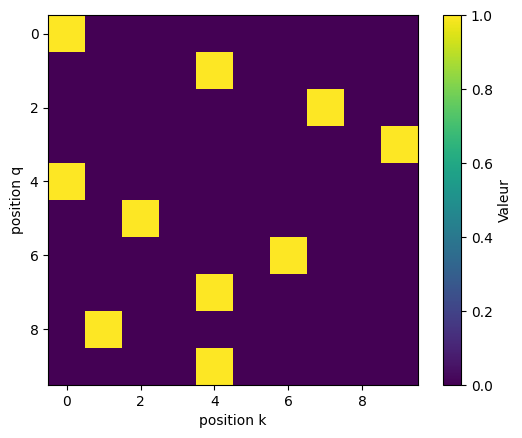

In [ ]:
output, attention_weights = trans_encoder.layers[0].mha.compute(x, x, x)
plt.imshow(attention_weights[0, 0])
plt.xlabel("position k")
plt.ylabel("position q")
plt.show()